# Overall performance of module detection methods

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

from modulescomparison import Modeval

import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil

conf_folder = "conf/"

from modulescomparison import Modeval

The following code will explore the parameters of a module detection method on every dataset using a grid-search approach.

It will then score the observed modules with known modules obtained from known regulatory networks.

In [2]:
datasetnames = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", "yeast_dream5"]

Every module detection method is wrapped in a python function (see lib/moduledetection.py)

Because module detection methods usually take a while to run (especially on , we generate the files necessary to run a method on the several parameter settings and datasets here. These can then be easily called from the commandline, for example on a computer cluster.

This function will be called by scripts/moduledetection.py , which will save the modules in the correct format along with additional run information (such as running times).

In [3]:
# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py

# choose the method to evaluate
method_name = "affinity"
methodblueprint = blueprints[method_name]

In [5]:
params_folder = "conf/paramexplo/" + method_name + "/"
if os.path.exists("../" + params_folder):
    shutil.rmtree("../" + params_folder)
os.makedirs("../" + params_folder)

methodsettings = []
method_locations = []
nreplicates = 1 # number of replicates using different seeds
i = 0
for dynparam_combination in list(itertools.product(*[methodblueprint["dynparams"][param] for param in sorted(methodblueprint["dynparams"].keys())])):
    for seed in range(nreplicates):
        method = {"params":{}}
        method["params"] = methodblueprint["staticparams"].copy()
        method["params"].update(dict(zip(sorted(methodblueprint["dynparams"].keys()), dynparam_combination)))
        method["location"] = params_folder + str(i) + ".json"
        method["seed"] = seed

        methodsettings.append(method)

        json.dump(method, open("../" + method["location"], "w"), cls=JSONExtendedEncoder)
        
        method_locations.append(method["location"])

        i+=1

In [6]:
settings_name = "paramexplo/{method_name}".format(method_name = method_name)
settings = [{
        "dataset_location":"conf/datasets/" + datasetname + ".json",
        "dataset_name":datasetname,
        "method_location":methodsetting["location"],
        "output_folder":"results/moduledetection/{settings_name}/{i}/".format(settings_name=settings_name, i=i)
    } for i, (datasetname, methodsetting) in enumerate(product(datasetnames, methodsettings))]
json.dump(settings, open("../conf/settings/{settings_name}.json".format(settings_name=settings_name), "w"))

In [7]:
commands = ""
for i, setting in enumerate(settings):
    commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -a " + commands_location)

parallel -a tmp/paramexplo/affinity.txt


Compare these detected modules with known modules (stored along with the datasets in data/).

In [95]:
modeval = Modeval(settings_name)
modeval.run(settings, pool)
modeval.save()

## Summarize across all methods

Now calculate for every method and module definition the test and training scores for every dataset.

In [11]:
scorename = "F1norm_rprr"

In [12]:
methodnames = ["flame", "kmedoids", "som", "kmeans", "cmeans", "spectral_similarity", 
               "affinity", "spectral_knn", "wgcna", "agglom", "hybrid", "divisive", 
               "sota", "dclust", "click", "dbscan", "meanshift", "clues", "ica_fdr", 
               "ica_zscore", "ica_percentage", "ipca", "pca", "spectral_biclust", 
               "isa", "biforce", "qubic", "plaid", "msbe", "opsm", "chengchurch"]

In [13]:
finalscores = []
for methodname in methodnames:
    print(methodname)
    
    paramsoi = methodparamsoi[methodname]
    
    settings_name = "paramexplo/" + methodname
    modeval = Modeval(settings_name)
    modeval.load()
    scores = modeval.scores
    # kmodscores contains all scores of a method on a particular module definition
    for kmodname, kmodscores in scores.groupby("knownmodules"):
        # get the best parameters on a dataset of reference (datasetor) and use these to score the performance on a dataset of interest (datasetoi)
        for (datasetoiname, scoresoi), (datasetorname, scoresor) in product(kmodscores.groupby("datasetname"), kmodscores.groupby("datasetname")):
            # find the most optimal method parameters
            bestparams = scoresor[paramsoi].ix[scoresor[scorename].idxmax()]

            # now find the of these parameters
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]

            finalscores.append({
                "datasetoi":datasetoiname,
                "datasetor":datasetorname,
                "score":scoresoi[scorename].ix[rowids].mean(),
                "method":methodname,
                "kmodname":kmodname
            })
finalscores = pd.DataFrame(finalscores)

flame
kmedoids
som
kmeans
cmeans
spectral_similarity
affinity
spectral_knn
wgcna
agglom
hybrid
divisive
sota
dclust
click
dbscan
meanshift
clues
ica_fdr
ica_zscore
ica_percentage
ipca
pca
spectral_biclust
isa
biforce
qubic
plaid
msbe
opsm
chengchurch


In [14]:
trainingscores = finalscores.ix[finalscores["datasetoi"] == finalscores["datasetor"]].groupby("method")["score"].mean()
testscores = finalscores.ix[finalscores["datasetoi"] != finalscores["datasetor"]].groupby("method")["score"].mean()

Visualize training and test scores

In [15]:
method_categories = OrderedDict([
    [
        "clustering", 
        ["flame", "kmedoids", "som", "kmeans", "cmeans", "spectral_similarity", "affinity", "spectral_knn", "wgcna", "agglom", "hybrid", "divisive", "sota", "dclust", "click", "dbscan", "meanshift", "clues"]
    
    ],
    [
        "decomposition", 
        ["ica_fdr", "ica_zscore", "ica_percentage", "ipca", "pca"],
    ],
    [
        "biclustering", 
        ["spectral_biclust", "isa", "biforce", "qubic", "plaid", "msbe", "opsm", "chengchurch"],
    ]
])
method2category = {methodname:category for category,methodnames in method_categories.items() for methodname in methodnames}

method_category_colors = modeval_category_colors = {
    "clustering":"#3498db",
    "decomposition":"#9b59b6",
    "biclustering":"#e74c3c",
    "ni_graphclust":"#a4cc2e",
    "iterativeni":"#FEB308",
    "other":"#555555"
}
method_category_backgroundcolors = {}
for category, color in modeval_category_colors.items():
    color = matplotlib.colors.rgb_to_hsv(matplotlib.colors.hex2color(color))
    color[1] = 0.2
    color[2] = 0.9
    color = matplotlib.colors.hsv_to_rgb(color)
    method_category_backgroundcolors[category] = color

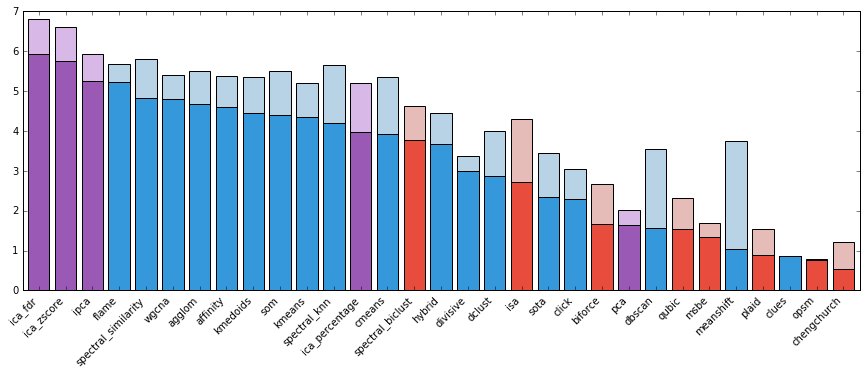

In [16]:
fig, ax = subplots(figsize=(15, 5))

methodorder = testscores.order(ascending=False).index

ax.bar(range(len(methodorder)), trainingscores[methodorder], color=[method_category_backgroundcolors[method2category[method]] for method in methodorder])
ax.bar(range(len(methodorder)), testscores[methodorder], color=[method_category_colors[method2category[method]] for method in methodorder])
ax.set_xlim(-0.2, len(methodorder))
ax.set_xticks(np.arange(len(methodorder))+0.4)
ax.set_xticklabels(methodorder, rotation=45, ha="right", va="top")